In [2]:
#imports and set up

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from IPython.display import display
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
%matplotlib notebook
from ipywidgets import interact, interactive, fixed #Sliders for image selection
import ipywidgets as widgets
mpl.rc('figure',  figsize=(4.77, 2.95))
mpl.rc('font', family='serif')
plt.rc('grid', linestyle="--", color='gray')
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  
import pims
import trackpy as tp
import pixiedust

Pixiedust database opened successfully


In [14]:
# function to provide gui file/folder picker

import tkinter as tk
from tkinter import filedialog

def pick_path():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askdirectory()
    return file_path

In [15]:
# select the directory containing the pictures you want to process
image_directory = pick_path()

In [16]:
#select the directory you wish to store trajectories in
general_directory = pick_path()
excel_directory = general_directory + ".xlsx"

if not os.path.exists(general_directory):
    os.makedirs(general_directory)

In [17]:
# confirm the correct image directory has been selected:
image_directory

'C:/Users/lc16629/OneDrive - University of Bristol/Desktop/Python/26-1-18 0.8gL 25C (1min) - REDUCED FRAMES'

In [18]:
#confirm the correct data directory has been selected
general_directory

'C:/Users/lc16629/OneDrive - University of Bristol/Desktop/Python/26-1-18 0.8gL 25C (1min) - REDUCED FRAMES/data 151119'

In [19]:
# import the images into the "frames" variable - only .tif files are selected
frames = pims.ImageSequence(image_directory + "/*.tif", as_grey=True)

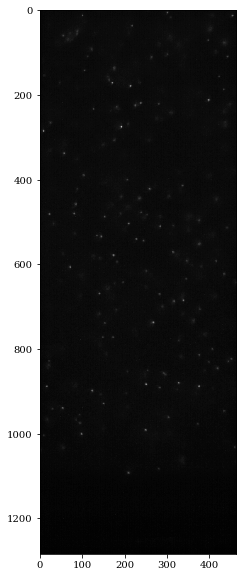

In [20]:
%matplotlib inline
# Show the first image use the cursor and text overlay to find the coordinates of the top left and 
# bottom right of the vial you wish to study, so the script can crop in to look at just the vial

plt.figure(figsize=(10,10))
plt.imshow(frames[-1])

def select_frame(frame_no):
    plt.imshow(frames[frame_no])

Note your x and y coordinates in this cell so that you remember them for the next cell (double click):
0 0 240 655

In [21]:
# input the area of interest within the image - i.e the vial being analysed.

top_left = input("top left coordinate, x then y, seperated by a space ").split()
bottom_right = input("bottom right coordinate, x then y, seperated by a space ").split()

top left coordinate, x then y, seperated by a space  0 0
bottom right coordinate, x then y, seperated by a space  560 1290


In [23]:
#Images are stored as Numpy arrays - crop them using list slicing syntax

def crop(frame):
    crop_coordinates = [int(i) for i in top_left + bottom_right]
    return frame[crop_coordinates[1]:crop_coordinates[3], crop_coordinates[0]:crop_coordinates[2]]

In [24]:
# Reload the images in the directory determined earlier, using the crop function to select only the area
# of interest as defined by the user earlier.
frames = pims.ImageSequence(image_directory + "/*.tif", process_func=crop)
%matplotlib inline
#Using ipywidgets, display the loaded frames, with a slider to scroll through them.
interact(select_frame, frame_no=widgets.IntSlider(min=0,max=len(frames)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_no', max=3502), Output()), _dom_classes=('widget-i…

<function __main__.select_frame(frame_no)>

In [25]:

# Similarly to before, scroll through the frames, after trackpy has analysed them for 'features'.
# Following that, some diagnostic plots are produced to check how well features have been identified

user_size=input("Please input a value for feature size (typically 5-10)" )
user_minmass=input("Please input a value for feature minmass (order 100-500)" )

feature_size = int(user_size)
feature_minmass = int(user_minmass) #min integrated brightness
feature_maxsize = 2.5
feature_separation = 0.1
feature_memory = 30 #missing feature reappearance frames
filter_stub_amount = 80 #Filter out trajectories with few points
feature_search_range = 10 #max distance a feature will move between frames in px

def show_annotated_frame(frame_no):
    plt.close("all")
    plt.figure(figsize = [10,10])
    f = tp.locate(frames[frame_no], feature_size, minmass=feature_minmass, maxsize=feature_maxsize, separation=feature_separation)
    tp.annotate(f, frames[frame_no])
    fig, ax = plt.subplots()
    ax.hist(f['mass'], bins=20)

    # Optionally, label the axes.
    ax.set(xlabel='mass', ylabel='count')
    
    plt.figure(figsize=[8,8])
    tp.subpx_bias(f);
    
    plt.figure()
    tp.mass_size(f)

interact(show_annotated_frame, frame_no=widgets.IntSlider(min=0,max=len(frames)-1,step=1,value=0))

Please input a value for feature size (typically 5-10) 9
Please input a value for feature minmass (order 100-500) 60


interactive(children=(IntSlider(value=0, description='frame_no', max=3502), Output()), _dom_classes=('widget-i…

<function __main__.show_annotated_frame(frame_no)>

In [ ]:
# running this cell will execute all the cells below - this is just for convinience - you don't 
# have to watch for each cell to finish so that you can run the next one

from IPython.display import Javascript
Javascript('IPython.notebook.execute_cells_below()')

In [26]:
import time
start = time.process_time()
track_full = tp.batch(frames[:10000], feature_size, minmass=feature_minmass)
#Locate features in all frames, returns dataframe
print(time.process_time() - start)

Frame 3502: 197 features
331.71875


In [27]:
tr_full = tp.link_df(track_full, feature_search_range, memory=feature_memory)
#Links features in track_full into trajectories


Frame 3502: 197 trajectories present.


Before: 35360
After: 691


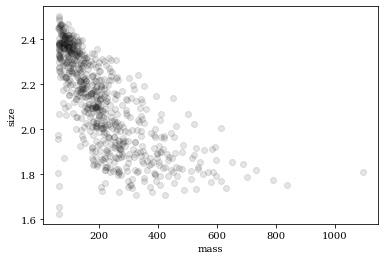

In [28]:
tr_full_filtered = tp.filter_stubs(tr_full, filter_stub_amount)
print('Before:', tr_full['particle'].nunique())
print('After:', tr_full_filtered['particle'].nunique())
# filter out short trajectories
plt.figure()
tp.mass_size(tr_full_filtered.groupby('particle').mean()); # convenience function -- just plots size vs. mass

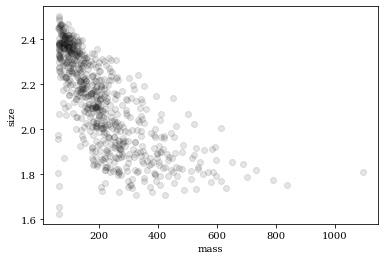

In [29]:
tr_full_filtered2 = tr_full_filtered[((tr_full_filtered['mass'] > 50) & (tr_full_filtered['size'] < 3))] ## Eccentricity filter -- & (tr_full_filtered['ecc'] < 1))]

# filter out abnormal objects from size-mass plot

plt.figure()
tp.mass_size(tr_full_filtered2.groupby('particle').mean());

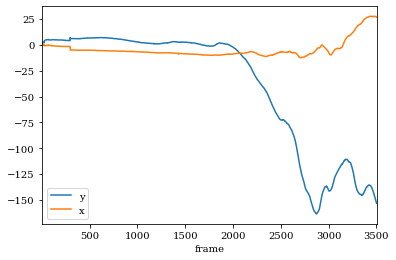

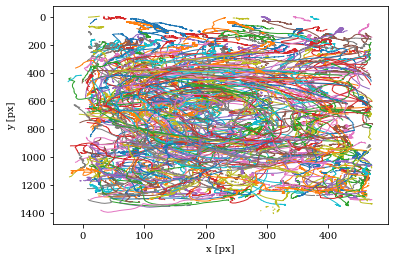

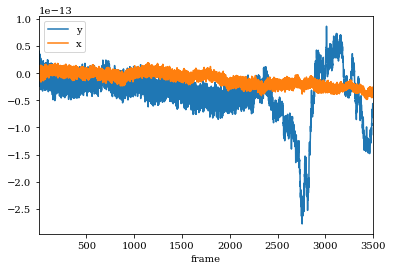

In [30]:
d = tp.compute_drift(tr_full_filtered2)
#calculate overall drifting motion of sample in cell
d.plot()
plt.show()


tr_full_drift = tp.subtract_drift(tr_full_filtered2.copy(), d)


ax = tp.plot_traj(tr_full_drift)
plt.show()

d = tp.compute_drift(tr_full_drift)
#calculate overall drifting motion of sample in cell
d.plot()
plt.show()


Drawing multicolor lines takes awhile. Come back in a minute.


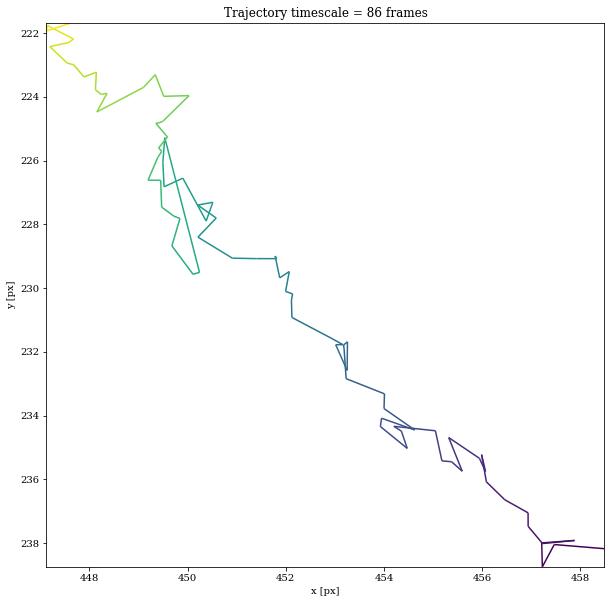

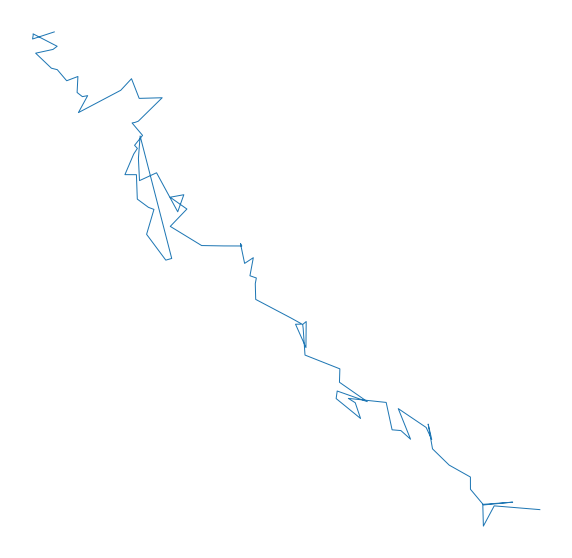

 Producing trajectory images for particles: 100.00%

In [31]:
import sys
from PIL import Image
import matplotlib.patches as mpl_patches

particles = tr_full_filtered2.particle.unique()

imgpath = (general_directory + "/trajectory images/unlabelled/")
if not os.path.exists(imgpath):
    os.makedirs(imgpath)
    
imgpath2 = (general_directory + "/trajectory images/labelled/")
if not os.path.exists(imgpath2):
    os.makedirs(imgpath2)    

for c, particle in enumerate(particles):
    
    sys.stdout.write("\r Producing trajectory images for particles: {:.2%}".format(c/len(particles)))
    sys.stdout.flush()
    
    p = tr_full_filtered2[tr_full_filtered2.particle == particle]
    
    # Produce LABELLED image of individual trajectory
    
    frame_scaled = (p.frame - p.frame.min())/p.frame.ptp()
    frame_range = (p.frame.max() - p.frame.min())
    
    
    plot2 = plt.figure(figsize=(10,10))
    plt.title("Trajectory timescale = %i" % frame_range + " frames")
    tp.plot_traj(p, colorby='frame', cmap=plt.cm.viridis)
    plot2.savefig(general_directory +"/trajectory images/labelled/img_" + str(particle) + ".png")    
    
    # Produce UNLABELLED image of individual trajectory
    
    plot = plt.figure(figsize=(10,10))
    plt.axis('off')
    tp.plot_traj(p, colour ='r')
    plot.savefig(general_directory +"/trajectory images/unlabelled/img_raw_" + str(particle) + ".png",
                bbox_inches = 'tight', pad_inches = 0)    
    

    
sys.stdout.write("\r Producing trajectory images for particles: {:.2%}".format(1 / 1))

In [40]:
# save the trajectories in a .pkl file to be used in Process_Data.ipynb

tr_full_drift.to_pickle(general_directory+"/trajectories" + ".pkl")

In [41]:
# store the frame dimensions you used in frame_dimensions.txt,
# dimensions are in pixels

f = open(general_directory + '/frame_dimensions.txt', 'w')
f.write(" ".join([str(x) for x in frames[0].shape]))
f.write("\n")
for dimension in [top_left, bottom_right]:
    f.write(" ".join([str(x) for x in dimension]))
    f.write("\n")
f.close()